1. Loading Data & Building Network Graph...
⚠️ Column 'device_user_agent' not found. Checking for 'device'...
   Adding connections to the graph...


Linking Locations: 100%|██████████| 20000/20000 [00:00<00:00, 606100.16it/s]


   Graph Built: 15311 nodes, 16876 connections.

2. Analyzing Network for Fraud Rings...
   Found 1 distinct communities.
   ⚠️ Detected 1 Suspicious Fraud Rings (Botnets)!

3. Calculating Risk Scores based on Centrality...


Scoring Users: 100%|██████████| 500/500 [00:00<00:00, 99969.11it/s]



4. Visualizing results...
   Saved graph image to 'fraud_ring_visualization.png'

✅ Network Analysis Complete. Risk scores exported to 'network_risk_scores.csv'.


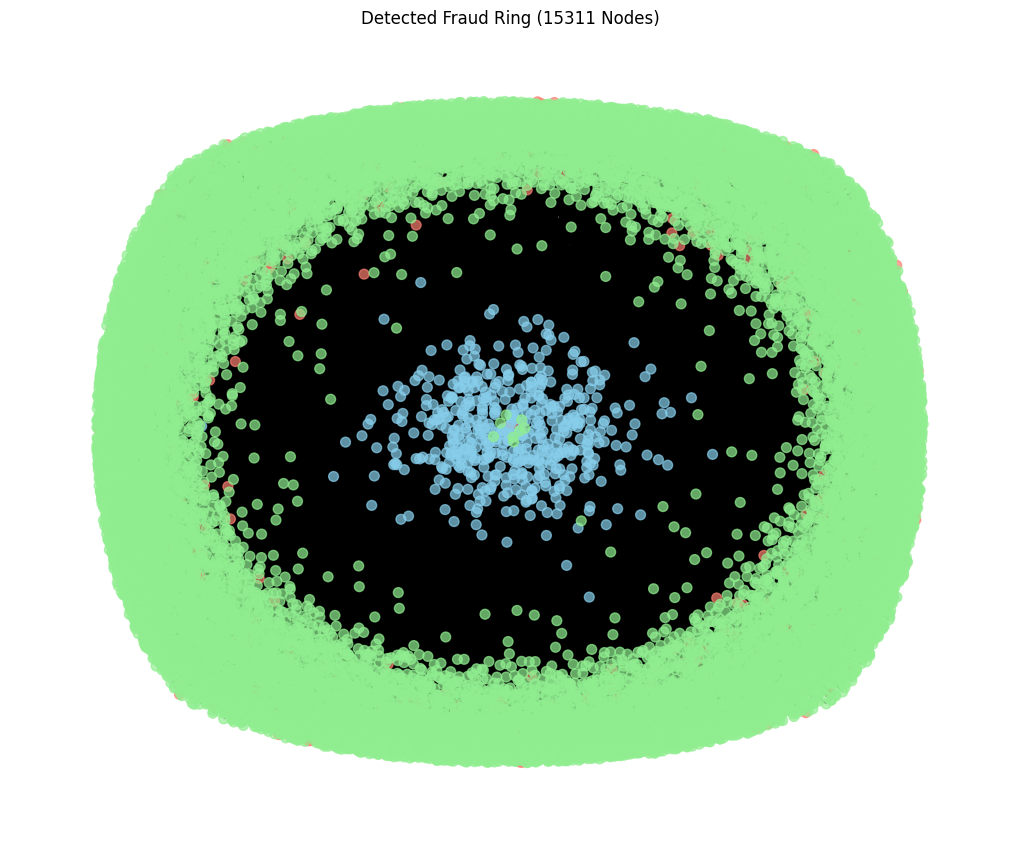

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ==========================================
# PART 1: DATA PREPARATION (Building the Web)
# ==========================================
print("1. Loading Data & Building Network Graph...")
# Load the high-quality logs we generated
df = pd.read_csv(r'C:\Users\abhis\OneDrive\Desktop\Models\phase1\user_logins.csv')

# --- CHANGE: STRICT COLUMN MAPPING ---
# We ensure we use 'device_user_agent' which matches the new generator
if 'device_user_agent' not in df.columns:
    print("⚠️ Column 'device_user_agent' not found. Checking for 'device'...")
    if 'device' in df.columns:
        df.rename(columns={'device': 'device_user_agent'}, inplace=True)
    else:
        raise ValueError("Could not find device column!")

# Create Edges: (User) -> (Device)
# A 'user' node connects to a 'device' node
edges_device = list(zip(df['user_id'], df['device_user_agent']))

# Create Edges: (User) -> (Location)
# We treat 'Lat,Lon' as a unique location node
df['location_id'] = df['lat'].astype(str) + "," + df['lon'].astype(str)
edges_location = list(zip(df['user_id'], df['location_id']))

# Initialize the Graph
G = nx.Graph()

# Add Edges (Connections)
print("   Adding connections to the graph...")
# Using tqdm to show progress because 20k rows can take a second
for u, d in tqdm(edges_device, desc="Linking Devices"):
    G.add_edge(u, d, type='device')

for u, l in tqdm(edges_location, desc="Linking Locations"):
    G.add_edge(u, l, type='location')

print(f"   Graph Built: {G.number_of_nodes()} nodes, {G.number_of_edges()} connections.")

# ==========================================
# PART 2: DETECTING FRAUD RINGS
# ==========================================
print("\n2. Analyzing Network for Fraud Rings...")

# ALGORITHM: Connected Components
# If User A shares an IP with User B, and User B shares a Device with User C...
# They are all in the same "Component".
components = list(nx.connected_components(G))
print(f"   Found {len(components)} distinct communities.")

# Find suspicious rings (Groups > 3 users connected together)
# We filter components to count how many *USERS* are in them (ignoring device nodes)
suspicious_rings = []
for comp in components:
    users_in_comp = [node for node in comp if str(node).startswith("user_")]
    if len(users_in_comp) > 3:
        suspicious_rings.append(comp)

print(f"   ⚠️ Detected {len(suspicious_rings)} Suspicious Fraud Rings (Botnets)!")

# ==========================================
# PART 3: CALCULATING RISK SCORES
# ==========================================
print("\n3. Calculating Risk Scores based on Centrality...")

# Degree Centrality: How many connections does a node have?
# High Degree = Used by many people (Shared Device/IP)
centrality = nx.degree_centrality(G)

network_risk_scores = {}

# We calculate a score for every USER based on their neighbors
users = [n for n in G.nodes() if str(n).startswith("user_")]

for user in tqdm(users, desc="Scoring Users"):
    risk = 0
    neighbors = G.neighbors(user)
    for neighbor in neighbors:
        # If I am connected to a "Super Node" (a device used by 100 people),
        # my risk skyrockets.
        risk += centrality[neighbor]
    
    network_risk_scores[user] = risk

# Normalize scores (0 to 1) for the AI model later
if network_risk_scores:
    max_risk = max(network_risk_scores.values())
    if max_risk > 0:
        for user in network_risk_scores:
            network_risk_scores[user] /= max_risk

# ==========================================
# PART 4: VISUALIZATION (Optional)
# ==========================================
print("\n4. Visualizing results...")
if suspicious_rings:
    # Get the largest ring
    largest_ring = max(suspicious_rings, key=len)
    subgraph = G.subgraph(largest_ring)
    
    plt.figure(figsize=(10, 8))
    # Spring layout tries to push nodes apart
    pos = nx.spring_layout(subgraph, k=0.15, iterations=20)
    
    color_map = []
    for node in subgraph:
        if str(node).startswith("user_"):
            color_map.append('skyblue') # User
        elif "Mozilla" in str(node): 
            color_map.append('salmon')  # Device
        else:
            color_map.append('lightgreen') # Location

    nx.draw(subgraph, pos, node_color=color_map, with_labels=False, node_size=50, alpha=0.7)
    plt.title(f"Detected Fraud Ring ({len(largest_ring)} Nodes)")
    plt.savefig("fraud_ring_visualization.png")
    print("   Saved graph image to 'fraud_ring_visualization.png'")

# ==========================================
# PART 5: EXPORT RESULTS
# ==========================================
risk_df = pd.DataFrame(list(network_risk_scores.items()), columns=['user_id', 'network_risk_score'])
risk_df.to_csv("network_risk_scores.csv", index=False)
print("\n✅ Network Analysis Complete. Risk scores exported to 'network_risk_scores.csv'.")